# SeSiMe
### Sentence/Sequence Similarity Measure

### Goal:  Compare/benchmark different similarity measures for MS-MS spectra
Import MS data and create documents.

Here: Use NOT Crusemann data, but other dataset where smilea are known for all spectra.
### here: GNPS Dataset of 11134 spectra with smiles.

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\labeled_MS_data\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
#mgf_file = PATH_MS_DATA + "GNPSLibraries_allSMILES.mgf"
mgf_file = PATH_MS_DATA + "GNPSLibraries_uniqueSMILES_withFeatureIDs.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0.01, #0
                 exp_intensity_filter = None, #0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


## Documents

+ Peaks were removed using an exponential fit to the peak intensity distribution. 
+ Words were created using 2 decimals.

### Interesting to note: 
+ Not discriminating between **loss** and **peak** has only very little influence on final result. Test was done with naming all peaks and losses by "mz_....". See load_MGF_data function using parameter: peak_loss_words = ['mz_', 'mz_']

In [4]:
# Have a look at how a document looks like:
print(MS_documents[0])

['peak_74.73', 'peak_79.02', 'peak_89.02', 'peak_89.04', 'peak_90.05', 'peak_95.05', 'peak_98.98', 'peak_105.04', 'peak_107.05', 'peak_117.03', 'peak_118.04', 'peak_134.67', 'peak_135.05', 'peak_135.28', 'peak_136.05', 'peak_137.00', 'peak_137.15', 'peak_145.03', 'peak_147.12', 'peak_160.09', 'peak_161.08', 'peak_162.59', 'peak_163.04', 'peak_163.08', 'peak_163.29', 'peak_164.04', 'peak_165.00', 'peak_165.40', 'peak_166.30', 'peak_167.15', 'peak_168.17', 'peak_172.58', 'peak_175.08', 'peak_181.06', 'peak_229.03', 'peak_237.01', 'peak_330.10', 'peak_330.14', 'loss_92.10', 'loss_100.08', 'loss_148.05', 'loss_154.04', 'loss_156.53', 'loss_160.95', 'loss_161.96', 'loss_162.81', 'loss_163.71', 'loss_164.11', 'loss_165.07', 'loss_165.82', 'loss_166.03', 'loss_166.07', 'loss_166.52', 'loss_168.04', 'loss_169.03', 'loss_182.00', 'loss_184.08', 'loss_191.96', 'loss_192.11', 'loss_193.07', 'loss_193.84', 'loss_194.07', 'loss_194.44', 'loss_211.07', 'loss_212.08', 'loss_222.06', 'loss_224.07', 'l

In [5]:
len(MS_documents)  # number of spectra = number of documents

9550

#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67455


### Note
In total it would be about 100.000 words. Many occur only once in the entire corpus and are hence filtered out (makes not sense to place them somewhere in word-space, would be arbitrary!).

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison!

## Word2Vec -based approach
### Compare different training parameters

+ Create Word2Vec based document centroid vectors based on models trained using different window sizes.

In [6]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(extra_weights = MS_documents_intensity, tfidf_weighted=True)
MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

  Calculated centroid vectors for  9550  of  9550  documents.of  9550  documents. Calculated centroid vectors for  540  of  9550  documents. Calculated centroid vectors for  910  of  9550  documents.1190  of  9550  documents. Calculated centroid vectors for  1270  of  9550  documents. Calculated centroid vectors for  2020  of  9550  documents. Calculated centroid vectors for  2600  of  9550  documents. Calculated centroid vectors for  2810  of  9550  documents. Calculated centroid vectors for  3780  of  9550  documents. Calculated centroid vectors for  8590  of  9550  documents.Calculated distances between  9550  documents.


This has calculated (cosine) distances between all spectra in an all-vs-all fashion.
The "num_hits" closest candidates for each spectrum are listed in two matrices.

One stores the distances, the other the respective IDs.

## Benchmark similarity measure

### Calculate molecular fingerprints
Here using: morgen-3 (alternative would be "daylight")  
Method will have problems with some smiles, those will be excluded from further analysis.

In [8]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Problem with molecule 7452
Problem with molecule 7522
Problem with molecule 7612
Problem with molecule 13527
Problem with molecule 13771
Problem with molecule 14111
Problem with molecule 14429
Problem with molecule 14652
Problem with molecule 15085
Problem with molecule 15140
Problem with molecule 15175
Problem with molecule 15531
Problem with molecule 15810
Problem with molecule 15981
Problem with molecule 15997
Problem with molecule 16095
Problem with molecule 16129
Problem with molecule 16151
Problem with molecule 16160
Problem with molecule 16163
Problem with molecule 16706
Problem with molecule 16707
Problem with molecule 16708
Problem with molecule 16709
Problem with molecule 16710
Problem with molecule 16711
Problem with molecule 16885
Problem with molecule 16981
Problem with molecule 17119
Problem with molecule 35001
Problem with molecule 35006
Problem with molecule 35008
Problem with molecule 35009
Problem with molecule 35013
Problem with molecule 35

### Get molecular similarity matrix (based on molecular fingerprints).  
Still named TANIMOTO, but that is only for daylight fingerprints. For morgan-3 fingerprints it's currently actually using a dice score.

In [9]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
tanimoto_similarities = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_m3,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


Load (or calculate if not present yet) the **Mol.Net** score matrix (carefull, calculating from scratch is slow!).

In [10]:
filename = PATH_SAVE_DATA + "MolNet_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_tol02_minmatch2_minintens_001.npy"
molnet_sim = MS_functions.molnet_matrix(spectra, 
                  tol = 0.2, 
                  max_mz = 1000, 
                  min_mz = 0, 
                  min_match = 2, 
                  min_intens = 0.01,
                  filename = filename)

MolNet similarity scores found and loaded.


### Explore ways to compare the different scores.

#### 1) Draw histograms of Tanimoto/Dice scores for the highest scoring similarity pairs. 

#### Baseline: Histogram of all Tanimoto/Dice scores

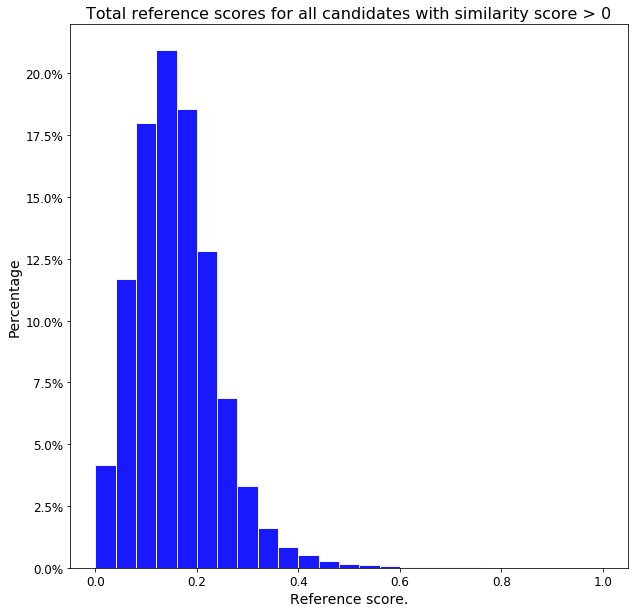

In [17]:
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, 0, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_baseline.png")
# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Top 10000 entries (+ top 5000 candidates) for Mol.Net score:

Set similarity threshold to:  0.9956584444975555


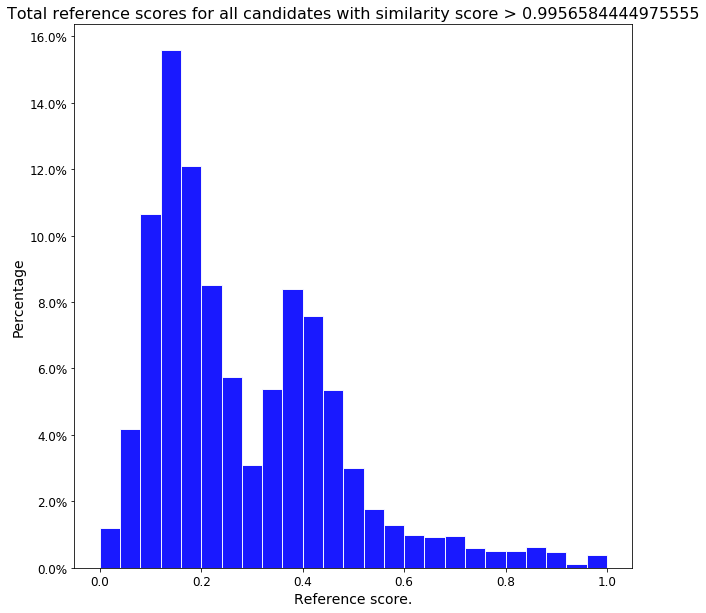

In [18]:
num_best = 10000
threshold = np.sort(molnet_sim.reshape(molnet_sim.shape[0]**2))[-(num_best + molnet_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(molnet_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_molnet.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Top 10000 entries (+ top 5000 candidates) for Word2Vec/Centroid score:

Set similarity threshold to:  0.8505918971390208


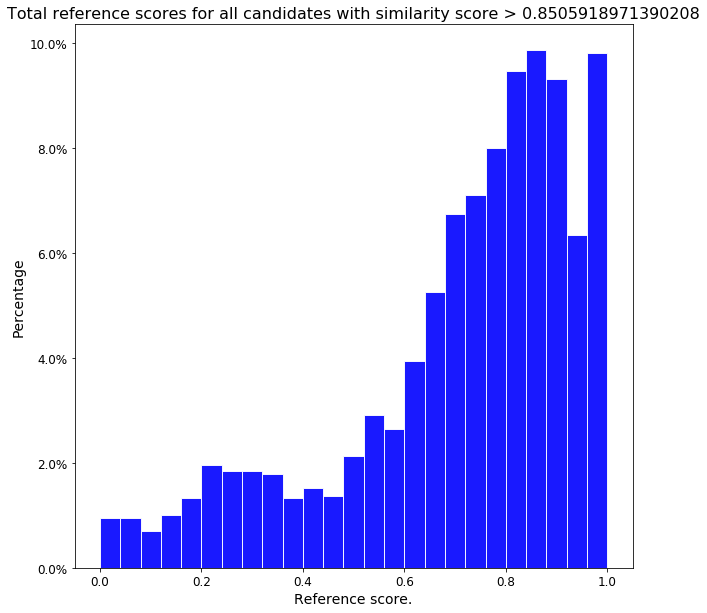

Percentage of highly similar molecules within selection:  83.4 %


In [16]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### Theoretical maxium based on Tanimoto/Dice scores only

Set similarity threshold to:  0.8631921824104235


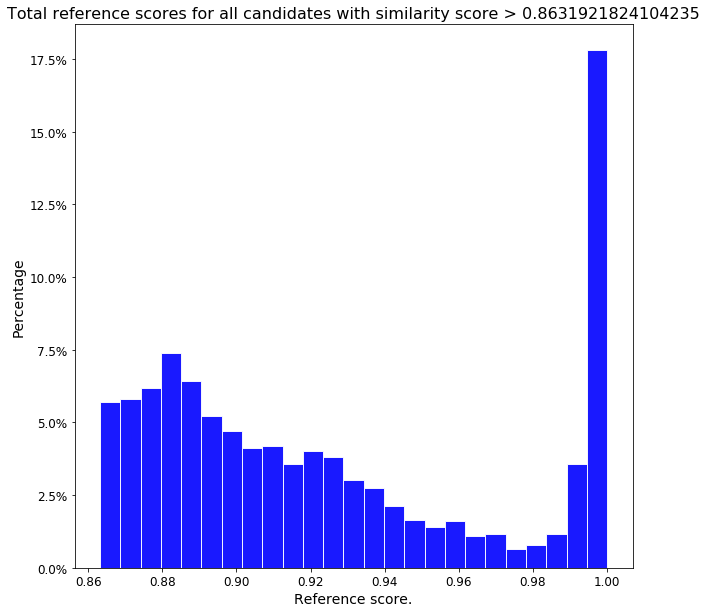

In [20]:
num_best = 10000
threshold = np.sort(tanimoto_similarities.reshape(tanimoto_similarities.shape[0]**2))[-(num_best + tanimoto_similarities.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(tanimoto_similarities, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_maximum.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Compare to other similarity measures:

## LDA

In [21]:
file_model_lda =  PATH_SAVE_MODEL + 'model_lda_MS_uniquesmiles_topic200_loss500_dec2.model' 
MS_measure.build_model_lda(file_model_lda, num_of_topics=200, num_pass=4, 
                        num_iter=100, use_stored_model=True)

Load stored LDA model ...


In [22]:
MS_measure.get_lda_similarity(num_hits=25)

In [26]:
import gensim 
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lda[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim[:,i] = similarities

Set similarity threshold to:  0.6641027927398682


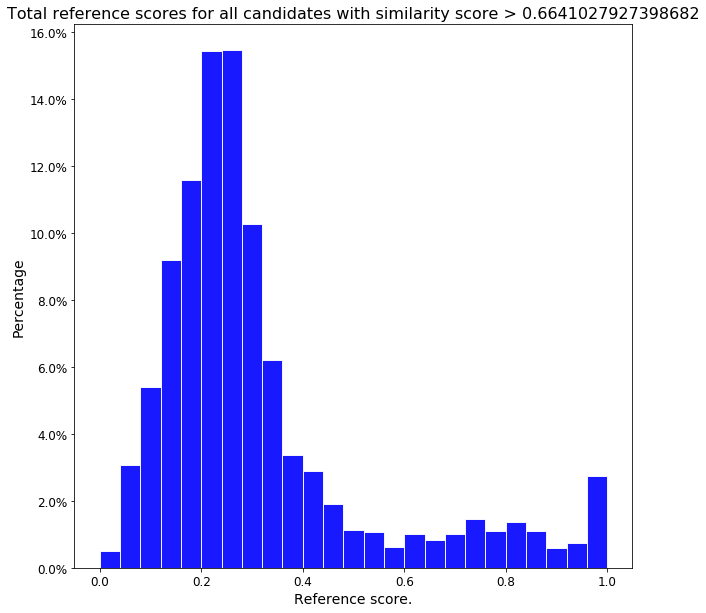

Percentage of highly similar molecules within selection:  14.72 %


In [27]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_lda.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## LSI

In [20]:
file_model_lsi =  PATH_SAVE_MODEL + 'model_lsi_MS_uniquesmiles_topic300_iter20_loss500_dec2.model' 
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=300, num_iter=20, use_stored_model=True)

Load stored LSI model ...


In [21]:
MS_measure.get_lsi_similarity(num_hits=25)

In [23]:
import gensim 
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lsi[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim_lsi = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim_lsi[:,i] = similarities

In [60]:
print(M_sim_lsi[:10,:10])

[[ 0.99999976  0.24683714  0.10210143  0.02026386  0.09987143 -0.00874199
   0.0755726   0.10318945  0.01997916  0.11776125]
 [ 0.24683714  0.99999964  0.30029091  0.07281049  0.16676907  0.16255526
   0.15694375  0.1459273   0.13910472  0.15488034]
 [ 0.10210143  0.30029091  0.99999982  0.23714505  0.13738906  0.22243787
   0.16508731  0.1247952   0.09515084  0.08775873]
 [ 0.02026386  0.07281049  0.23714505  1.00000024  0.30992481  0.29913828
   0.11534653  0.09305678  0.05892274  0.1255189 ]
 [ 0.09987143  0.16676907  0.13738906  0.30992481  0.99999982  0.25611559
   0.09918535  0.10797343  0.12047406  0.10059546]
 [-0.00874199  0.16255526  0.22243787  0.29913828  0.25611559  1.00000048
   0.23527184  0.08326226  0.17453124  0.10188346]
 [ 0.0755726   0.15694375  0.16508731  0.11534653  0.09918535  0.23527184
   1.00000024  0.25638512  0.15085153  0.12101997]
 [ 0.10318945  0.1459273   0.1247952   0.09305678  0.10797343  0.08326226
   0.25638512  1.00000012  0.24479812  0.12051262]


Set similarity threshold to:  0.669819712638855


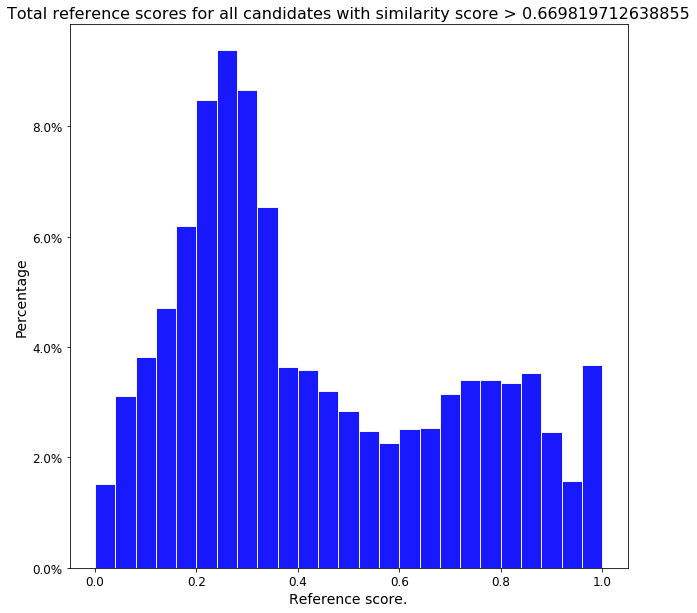

Percentage of highly similar molecules within selection:  37.2 %


In [24]:
num_best = 10000
threshold = np.sort(M_sim_lsi.reshape(M_sim_lsi.shape[0]**2))[-(num_best + M_sim_lsi.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_lda.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## GloVe

In [11]:
file_model_glove = PATH_SAVE_MODEL + 'model_glove_MS_uniquesmiles_d300_w300_iter10_loss500_minpeak10_dec2.model'
MS_measure.build_model_glove(file_model_glove, vector_size=300, window=300, 
                             learning_rate=0.05, workers=8, epochs=10, 
                             use_stored_model=True)

Load stored GloVe model ...


In [12]:
# Use peak intensities as extra weights
MS_measure.get_vectors_glove(extra_weights = MS_documents_intensity, tfidf_weighted=True)
MS_measure.get_glove_similarity(num_hits=25, method='cosine')

  Calculated GloVe vectors for  9550  of  9550  documents.Calculated GloVe vectors for  620  of  9550  documents. documents. Calculated GloVe vectors for  1990  of  9550  documents. 2070  of  9550  documents.2230  of  9550  documents.2790  of  9550  documents. Calculated GloVe vectors for  3940  of  9550  documents. of  9550  documents. Calculated GloVe vectors for  7120  of  9550  documents. Calculated GloVe vectors for  8490  of  9550  documents. Calculated GloVe vectors for  8680  of  9550  documents. 9090  of  9550  documents.Calculated distances between  9550  documents.


In [14]:
from scipy import spatial
M_sim = 1 - spatial.distance.cdist(MS_measure.vectors_glove, MS_measure.vectors_glove, 'cosine')

Set similarity threshold to:  0.9713280472075719


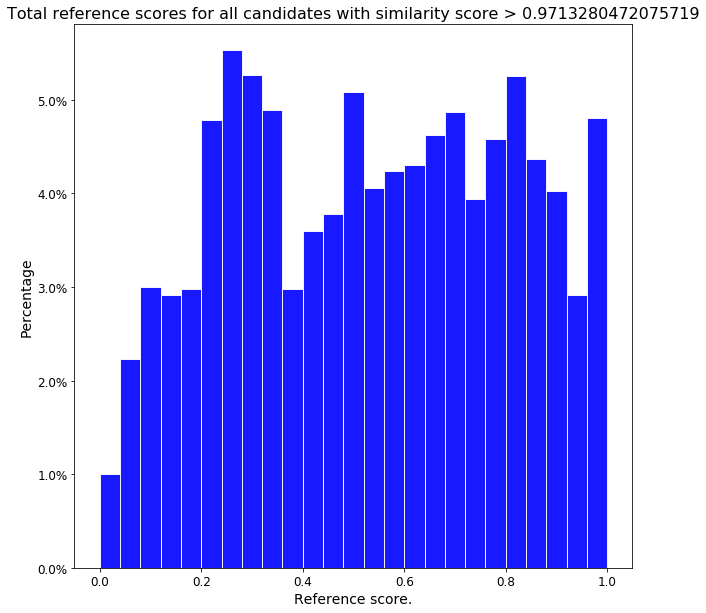

Percentage of highly similar molecules within selection:  57.06 %


In [15]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_glove.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [17]:
# Compare to case without using intensities as extra weights
MS_measure.get_vectors_glove(extra_weights = None, tfidf_weighted=True)
MS_measure.get_glove_similarity(num_hits=25, method='cosine')

  Calculated GloVe vectors for  9550  of  9550  documents.  of  9550  documents.Calculated distances between  9550  documents.


In [18]:
from scipy import spatial
M_sim = 1 - spatial.distance.cdist(MS_measure.vectors_glove, MS_measure.vectors_glove, 'cosine')

Set similarity threshold to:  0.9709511323748968


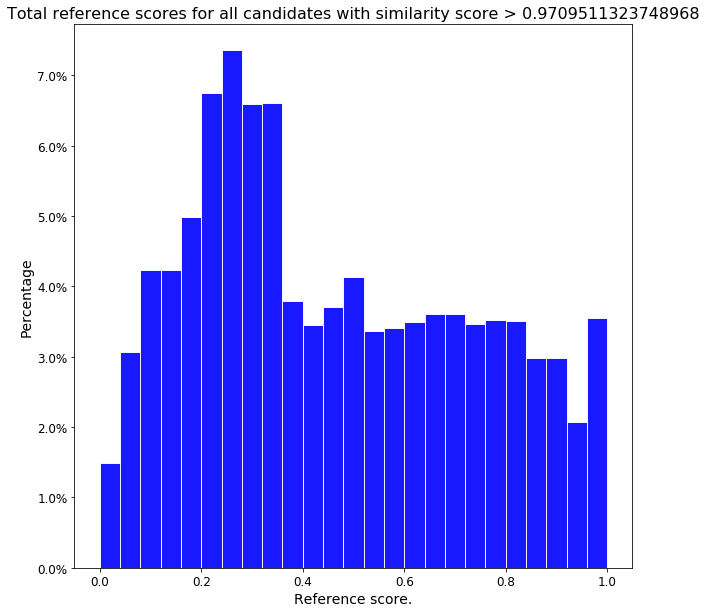

Percentage of highly similar molecules within selection:  43.72 %


In [19]:
num_best = 10000
threshold = np.sort(M_sim.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_glove2.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## Consider combined scores as well

Set similarity threshold to:  0.4646899778400136


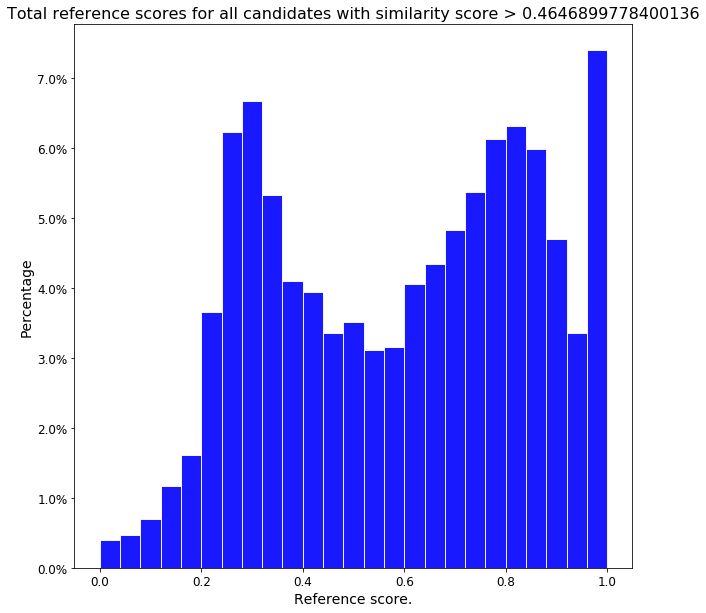

Percentage of highly similar molecules within selection:  62.33 %


In [25]:
num_best = 10000
M_combine = M_sim_ctr * M_sim_lsi
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

Set similarity threshold to:  0.6694727948551927


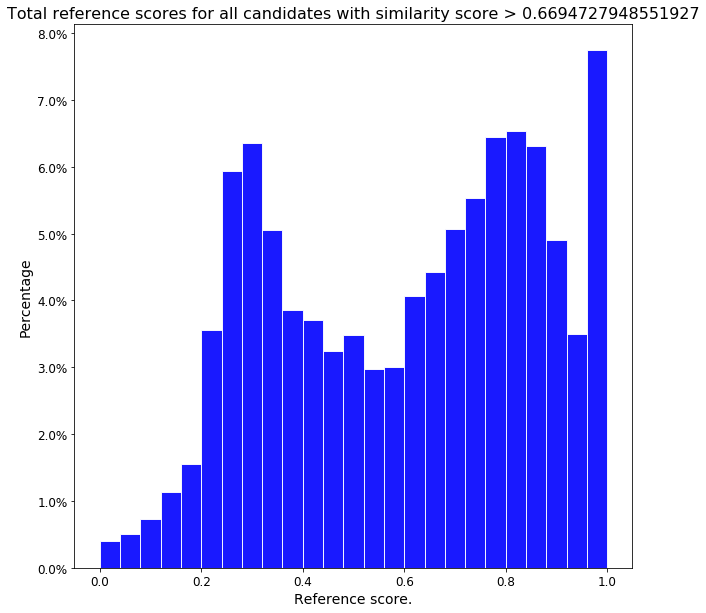

Percentage of highly similar molecules within selection:  63.99 %


In [27]:
num_best = 10000
M_combine = M_sim_ctr * M_sim_lsi + 0.2 * M_sim_ctr + 0.08 * M_sim_lsi
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine2.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

Set similarity threshold to:  0.8247826153957303


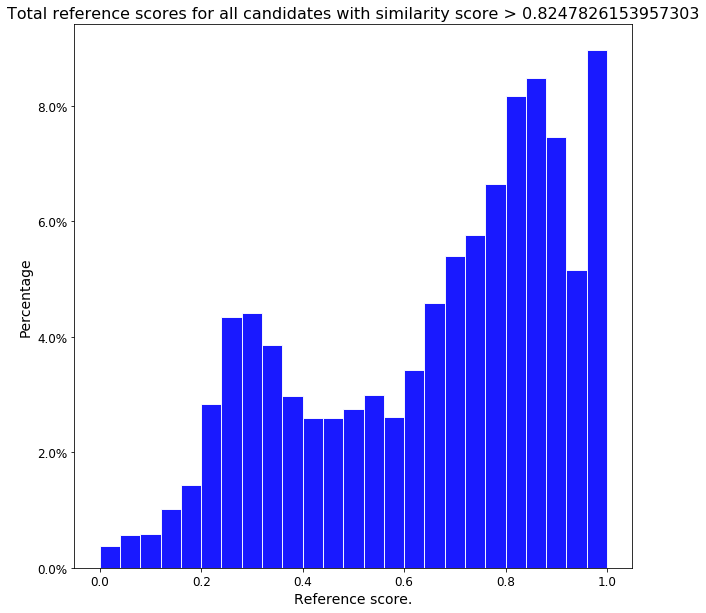

Percentage of highly similar molecules within selection:  72.41 %


In [32]:
num_best = 10000
M_combine = 0.55 * M_sim_ctr  + 0.1 * M_sim_lsi + 0.35 * M_sim
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine3.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

#### So far, doesn't seem to perform better than word2vec alone!
(using this type of benchmarking measure)

Set similarity threshold to:  0.8633877063117205


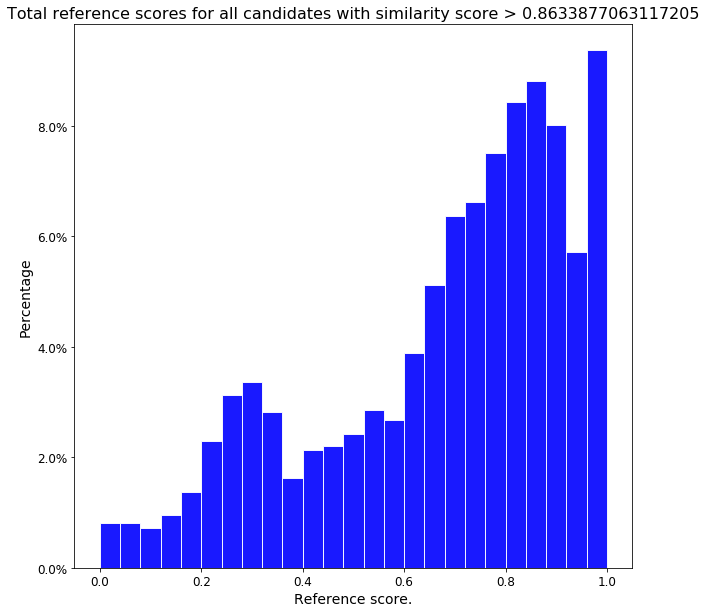

Percentage of highly similar molecules within selection:  77.77 %


In [41]:
num_best = 10000
M_combine = M_sim_ctr * (M_sim_ctr>0.5) + M_sim_lsi * (M_sim_lsi > 0.7)
threshold = np.sort(M_combine.reshape(M_sim.shape[0]**2))[-(num_best + M_sim.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_combine, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_combine.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Note: Comparing different molecular fingerprints!
Technically, Tanimoto is not the right naming here!
For the rdkit default fingerprints (**Daylight**) I here indeed used Tanimoto similarity to compare fingerprints. 

But for the morgen-3 or **ECFP-6** finterprints it is actually a Dice score!

In [34]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

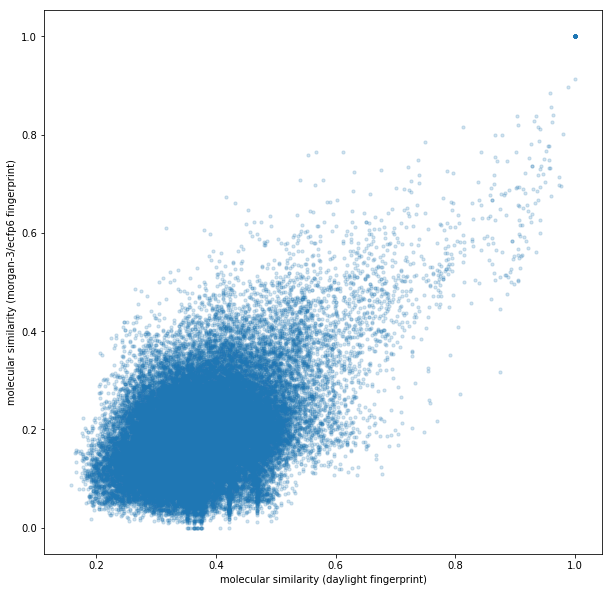

In [233]:
# Agreement between daylight and morgan-3/ecfp6 fingerprint-based molecular similarity.
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_daylight[:300,:300], tanimoto_similarities[:300,:300], s=10, alpha=0.1)
plt.ylabel("molecular similarity (morgan-3/ecfp6 fingerprint)")
plt.xlabel("molecular similarity (daylight fingerprint)")

#### Compare morgan-3 scores (Dice score) with word2vec/centroid scores

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

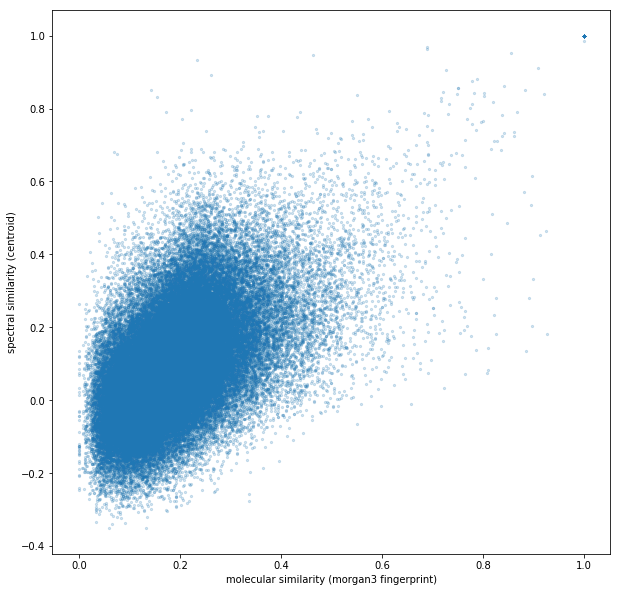

In [36]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:400,:400], M_sim_ctr[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

### Zoom in to high similarity values

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

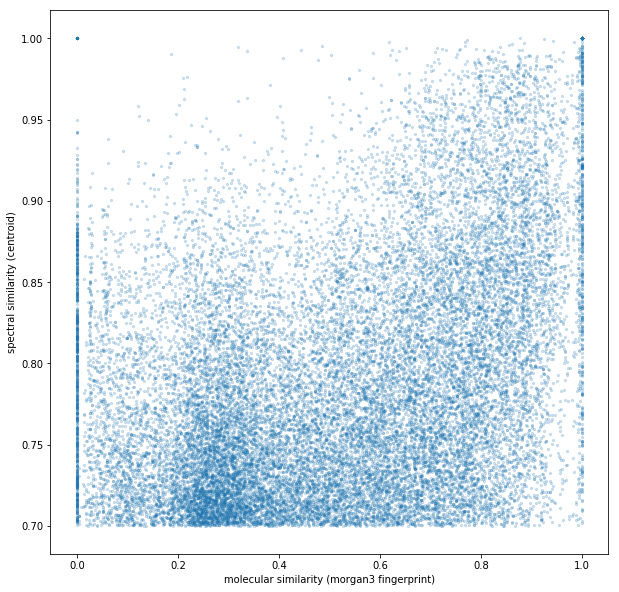

In [38]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
#select = np.where(tanimoto_similarities_m3 > 0.6)
select = np.where(M_sim_ctr > 0.7)
ax.scatter(tanimoto_similarities[select], M_sim_ctr[select], s=5, alpha=0.1)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0, 0.5, 'spectral similarity (LSI)')

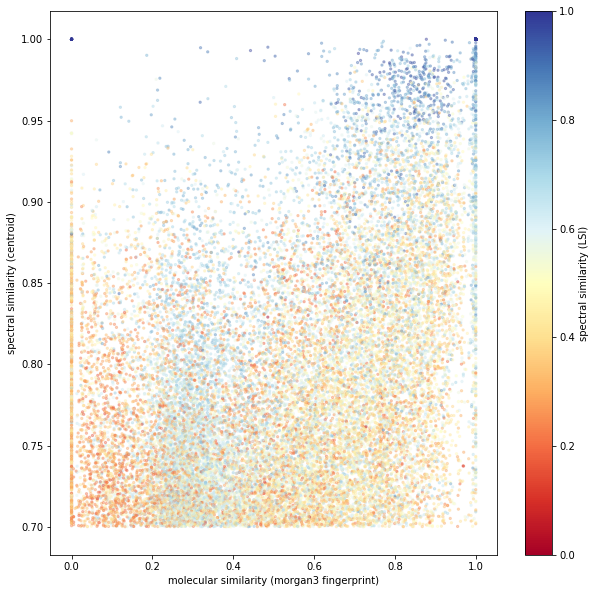

In [63]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid) and LSI scores
select = np.where(M_sim_ctr > 0.7)

import matplotlib
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')
ax.scatter(tanimoto_similarities[select], M_sim_ctr[select], s=5, c=M_sim_lsi[select], cmap=cm, alpha=0.2)
plt.ylabel("spectral similarity (centroid)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

# Optionally add a colorbar
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm)
plt.ylabel("spectral similarity (LSI)")

### Compare molecular similarity scores with Mol.Net scoring

Text(0.5, 0, 'molecular similarity (morgan-3 fingerprint)')

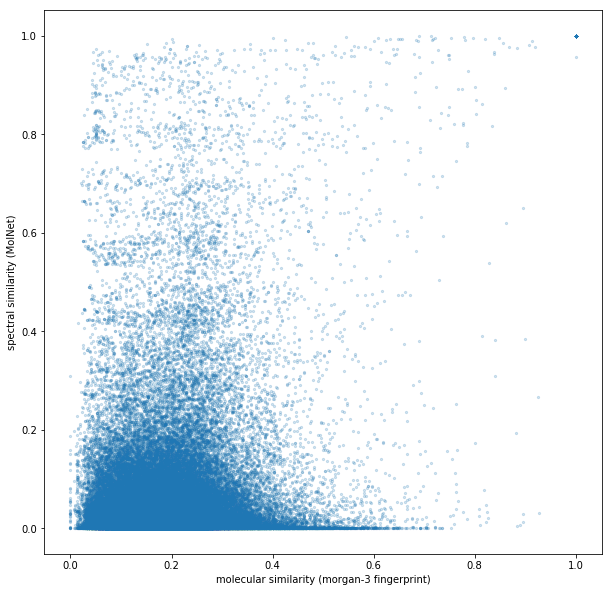

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:400,:400], molnet_sim[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (MolNet)")
plt.xlabel("molecular similarity (morgan-3 fingerprint)")

#### Compare morgan-3 scores (Dice score) with LSI scores

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

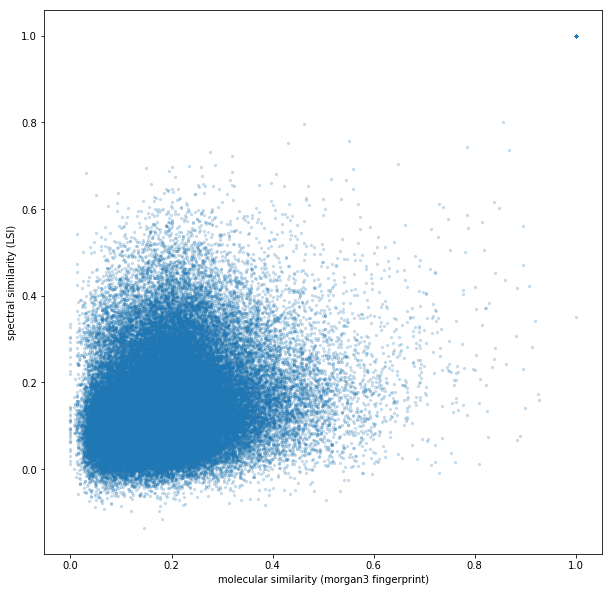

In [64]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities[:400,:400], M_sim_lsi[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (LSI)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

In [65]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_day, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "daylight")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Problem with molecule 7452
Problem with molecule 7522
Problem with molecule 7612
Problem with molecule 13527
Problem with molecule 13771
Problem with molecule 14111
Problem with molecule 14429
Problem with molecule 14652
Problem with molecule 15085
Problem with molecule 15140
Problem with molecule 15175
Problem with molecule 15531
Problem with molecule 15810
Problem with molecule 15981
Problem with molecule 15997
Problem with molecule 16095
Problem with molecule 16129
Problem with molecule 16151
Problem with molecule 16160
Problem with molecule 16163
Problem with molecule 16706
Problem with molecule 16707
Problem with molecule 16708
Problem with molecule 16709
Problem with molecule 16710
Problem with molecule 16711
Problem with molecule 16885
Problem with molecule 16981
Problem with molecule 17119
Problem with molecule 35001
Problem with molecule 35006
Problem with molecule 35008
Problem with molecule 35009
Problem with molecule 35013
Problem with molecule 35

## Compare to  'daylight' molecular fingerprints.  
Tanimoto score on daylight-like molecular fingerprints (rdkit).

In [66]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2.npy"
tanimoto_similarities_daylight = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_day,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


Text(0.5, 0, 'molecular similarity (daylight fingerprint)')

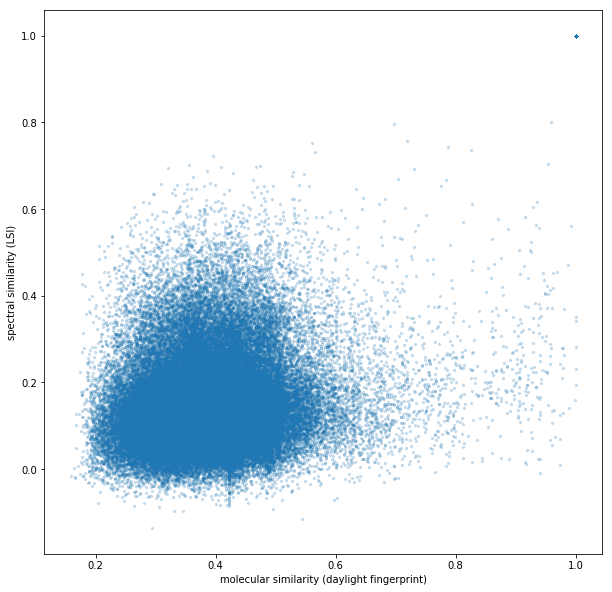

In [67]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_daylight[:400,:400], M_sim_lsi[:400,:400], s=5, alpha=0.1)
plt.ylabel("spectral similarity (LSI)")
plt.xlabel("molecular similarity (daylight fingerprint)")

Set similarity threshold to:  0.669819712638855


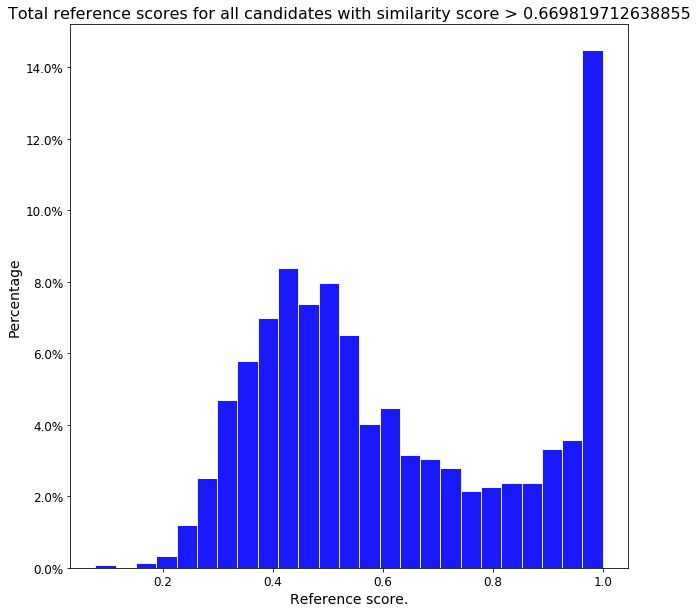

Percentage of highly similar molecules within selection:  54.53 %


In [68]:
num_best = 10000
threshold = np.sort(M_sim_lsi.reshape(M_sim_lsi.shape[0]**2))[-(num_best + M_sim_lsi.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities_daylight, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_lda.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Searching for cases where molnet and word2vec-based measures disagree a lot

In [34]:
from MS_functions import evaluate_measure
num_candidates = 11
mol_sim, spec_sim, spec_idx, reference_list = evaluate_measure(spectra_dict, spectra,
                                                                  MS_measure, 
                                                                   fingerprints,
                                                                   num_candidates = num_candidates,
                                                                   num_of_molecules = "all", #5000,
                                                                   similarity_method = "centroid", #"molnet",
                                                                   reference_list = None)


  Evaluate spectrum  9550  of  9550  spectra. Evaluate spectrum  2560  of  9550  spectra. spectra.  of  9550  spectra.

In [35]:
from MS_functions import evaluate_measure
num_candidates = 11
mol_sim2, spec_sim2, spec_idx2, reference_list2 = evaluate_measure(spectra_dict, spectra,
                                                                  MS_measure, 
                                                                   fingerprints,
                                                                   num_candidates = num_candidates,
                                                                   num_of_molecules = "all", #5000,
                                                                   similarity_method = "molnet",
                                                                   molnet_sim = molnet_sim,
                                                                   reference_list = None)

  Evaluate spectrum  9550  of  9550  spectra.  spectra.

## Further tests with other measure (lsi, pca etc.)

Compare to word2vec and also test combinations!

### Try different similarity measuring methods...

#### A) LSI
LSI topic modeling....

In [240]:
file_model_lsi =  PATH_SAVE_MODEL + 'model_lsi_MS_uniquesmiles_topic300_iter20_loss500_minpeak10_dec2.model' 
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=300, num_iter=20, use_stored_model=True)

Stored LSI model not found!
Calculating new LSI model...


In [241]:
MS_measure.get_lsi_similarity(num_hits=25)

In [243]:
import gensim
from gensim.test.utils import get_tmpfile
index_tmpfile = get_tmpfile("index")
index = gensim.similarities.Similarity(index_tmpfile, MS_measure.model_lsi[MS_measure.bow_corpus], 
                                       num_features=len(MS_measure.dictionary))  # build the index
M_sim_lsi = np.zeros((len(MS_measure.corpus), len(MS_measure.corpus)))
for i, similarities in enumerate(index):  # yield similarities of all indexed documents
    M_sim_lsi[:,i] = similarities

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

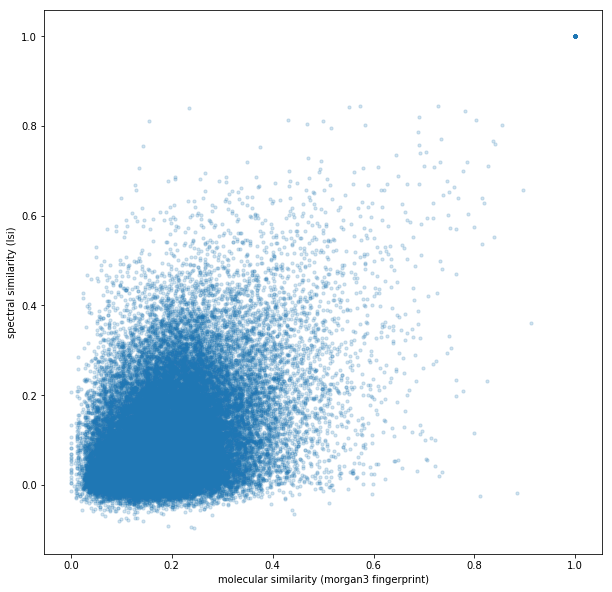

In [248]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:300,:300], M_sim_lsi[:300,:300], s=10, alpha=0.1)
plt.ylabel("spectral similarity (lsi)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

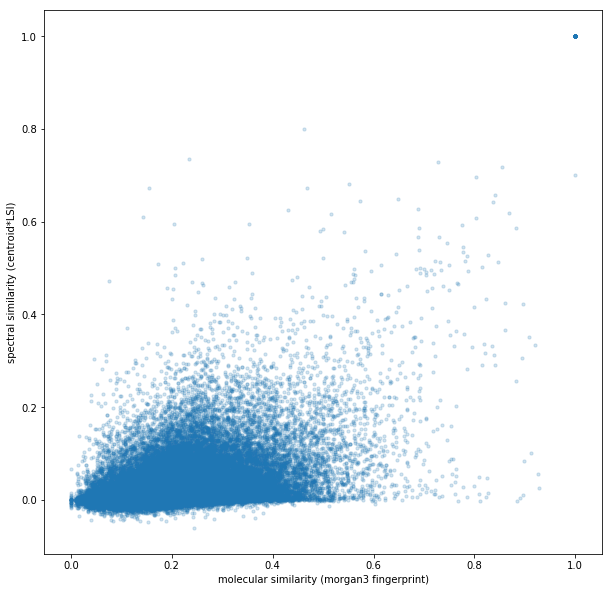

In [267]:
# measure agreement between molecular similarity (morgan3 fingerprint) and spectral similarity (centroid)
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(tanimoto_similarities_m3[:400,:400], M_sim_ctr[:400,:400]*M_sim_lsi[:400,:400], s=10, alpha=0.1)
plt.ylabel("spectral similarity (centroid*LSI)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

Text(0.5, 0, 'molecular similarity (morgan3 fingerprint)')

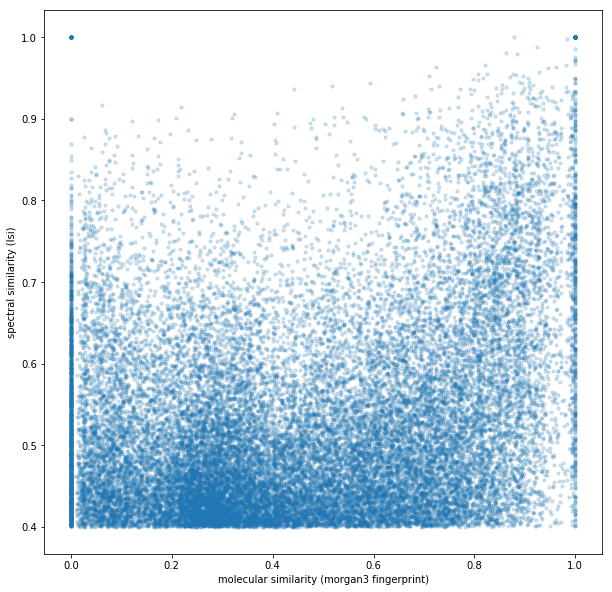

In [269]:
fig, ax = plt.subplots(figsize=(10,10))
#select = np.where(tanimoto_similarities_m3 > 0.7)
select = np.where(M_sim_lsi*M_sim_ctr > 0.4)
ax.scatter(tanimoto_similarities_m3[select], M_sim_lsi[select]*M_sim_ctr[select], s=10, alpha=0.1)
plt.ylabel("spectral similarity (lsi)")
plt.xlabel("molecular similarity (morgan3 fingerprint)")

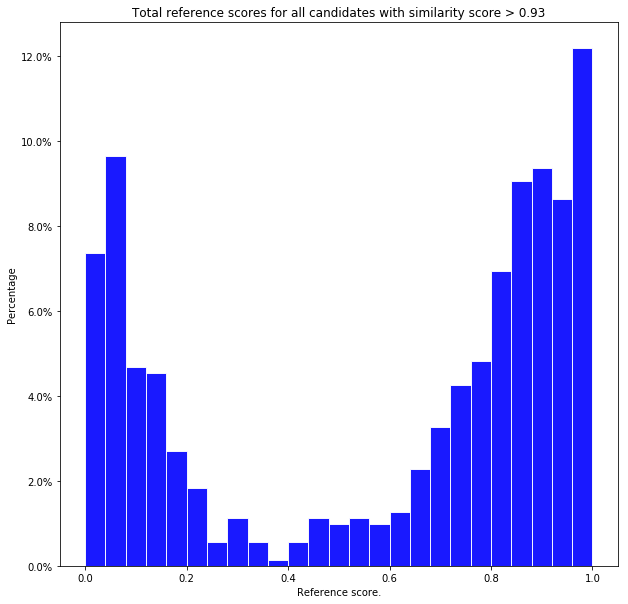

In [262]:
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]
n, bins = MS_functions.similarity_histogram(M_sim_lsi, tanimoto_similarities_m3, 0.93, 
                                            num_bins=25, exclude_IDs = exclude)

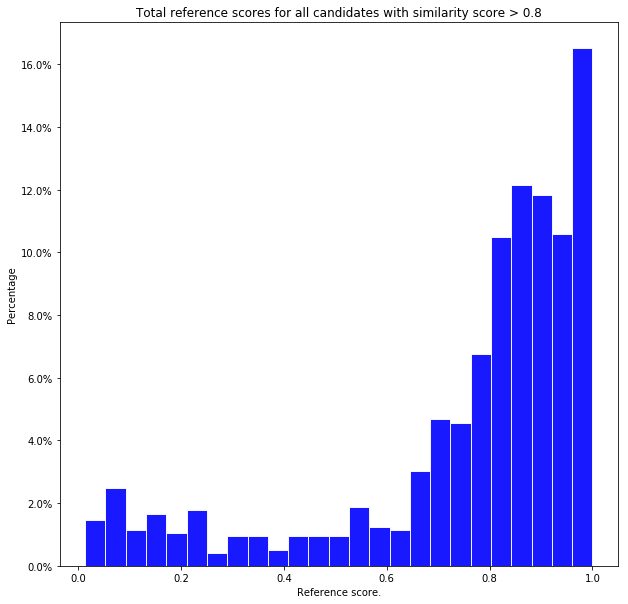

In [264]:

n, bins = MS_functions.similarity_histogram(M_sim_ctr*M_sim_lsi, tanimoto_similarities_m3, 0.8, 
                                            num_bins=25, exclude_IDs = exclude)

In [265]:
np.sum(n[12:])

0.8577362409138103

In [261]:
#np.sum(M_sim_ctr*M_sim_lsi >0.8)
np.sum(M_sim_lsi >0.93)

10970